In [1]:
import os
import glob
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)

In [2]:
# read in files 
extension = 'csv'
all_filenames = [i for i in glob.glob('FedEx_invoice*.{}'.format(extension))]
all_filenames

['FedEx_invoice_2022-01-19_04-46.csv', 'FedEx_invoice_2022-01-26_03-57.csv']

In [3]:
# reading in df fails since a column has commas
headers = [*pd.read_csv('FedEx_invoice_2022-01-19_04-46.csv', nrows=1)]
headers_keep = ["Payor","Express or Ground Tracking ID","Net Charge Amount","Service Type","Shipment Date","POD Delivery Date",
"Actual Weight Amount","Rated Weight Amount","Dim Length","Dim Width","Dim Height","Dim Divisor","Recipient Name",
"Recipient Company","Recipient Address Line 1","Recipient Address Line 2","Recipient City","Recipient State","Recipient Zip Code",
"Shipper Company","Shipper Name","Shipper Address Line 1","Shipper Address Line 2","Shipper City","Shipper State",
"Shipper Zip Code","Original Customer Reference","Original Ref#2","Original Ref#3/PO Number","Zone Code"]

In [4]:
# append invoices to dataframe 
df_master = pd.DataFrame()
for file in all_filenames:
    df = pd.read_csv(file, usecols= headers_keep )
    df_master = df_master.append(df)

In [5]:
# copy dataframe and start cleaning
df = df_master.copy()

# convert to integer 
df[['POD Delivery Date', 'Recipient Zip Code', 'Original Ref#2', 'Original Ref#3/PO Number']] = df[['POD Delivery Date', 'Recipient Zip Code', 'Original Ref#2', 'Original Ref#3/PO Number']].astype('Int64')
  
# convert to datetime
from datetime import date
today = date.today()
d1 = int(today.strftime("%Y%m%d"))
df['POD Delivery Date'] = df['POD Delivery Date'].fillna(d1)
df['POD Delivery Date'] = pd.to_datetime(df['POD Delivery Date'], format='%Y%m%d')
df['Shipment Date'] = df['Shipment Date'].fillna(d1)
df['Shipment Date'] = pd.to_datetime(df['Shipment Date'], format='%Y%m%d')

In [6]:
# calculate true total charge -- adjustments are added as a second line with duplicate tracking numbers
df_tot_cost = pd.DataFrame()
df_tot_cost['Total Cost'] = df[['Express or Ground Tracking ID', 'Net Charge Amount']].groupby(by = 'Express or Ground Tracking ID').sum()
df_tot_cost.rename_axis("Express or Ground Tracking ID")

# append to DF as Total Cost
df = pd.merge(df,df_tot_cost['Total Cost'], 
                                    on ='Express or Ground Tracking ID', how='inner')

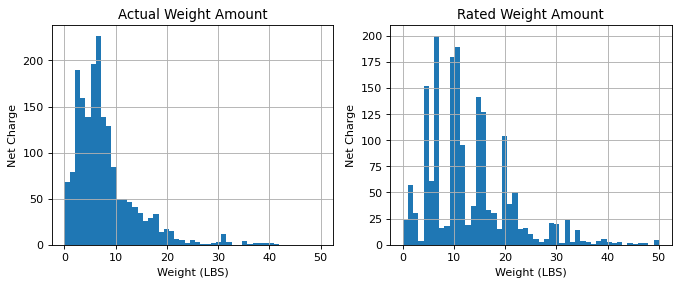

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80);

ax1 = plt.subplot(2, 2, 1)
HIST_BINS = np.linspace(0,50, 50)
ax1.set_title('Actual Weight Amount')
ax1.set_xlabel('Weight (LBS)')
ax1.set_ylabel('Net Charge')
ax1 = df['Actual Weight Amount'].hist(bins=HIST_BINS);

ax2 = plt.subplot(2, 2, 2)
HIST_BINS = np.linspace(0,50, 50)
ax2.set_title('Rated Weight Amount')
ax2.set_xlabel('Weight (LBS)')
ax2.set_ylabel('Net Charge')
ax2 = df['Rated Weight Amount'].hist(bins=HIST_BINS);

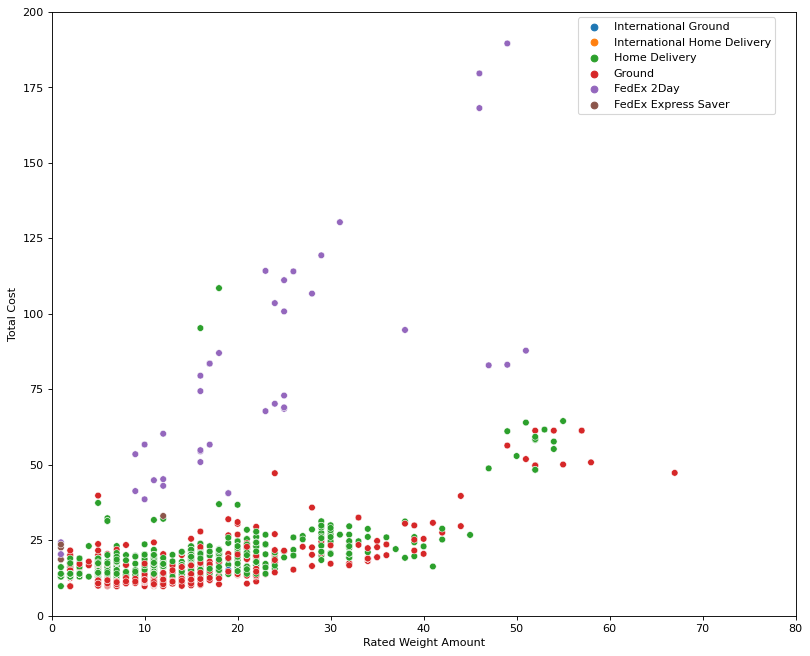

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80);

sns.scatterplot(x='Rated Weight Amount',
               y = 'Total Cost',
               hue = 'Service Type',
               data = df);

plt.xlim(0, 80)
plt.ylim(0, 200)

plt.legend(loc='best', bbox_to_anchor=(.7, 0., .6, 1));

In [9]:
df['Total Cost'].describe()

count    1835.000000
mean       18.953248
std        19.471176
min         9.790000
25%        13.530000
50%        15.670000
75%        19.000000
max       585.340000
Name: Total Cost, dtype: float64

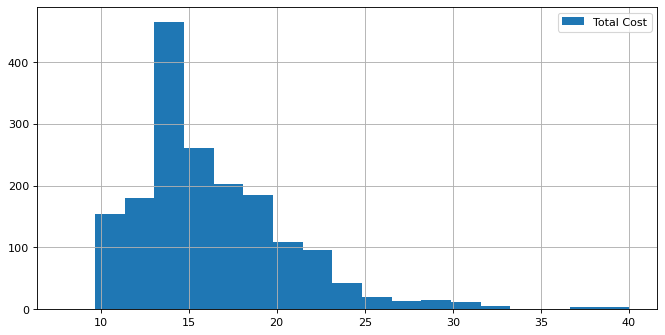

In [10]:
figure(figsize=(10, 5), dpi=80);
HIST_BINS = np.linspace(8,40, 20)
df['Total Cost'].hist(bins=HIST_BINS, legend=True);

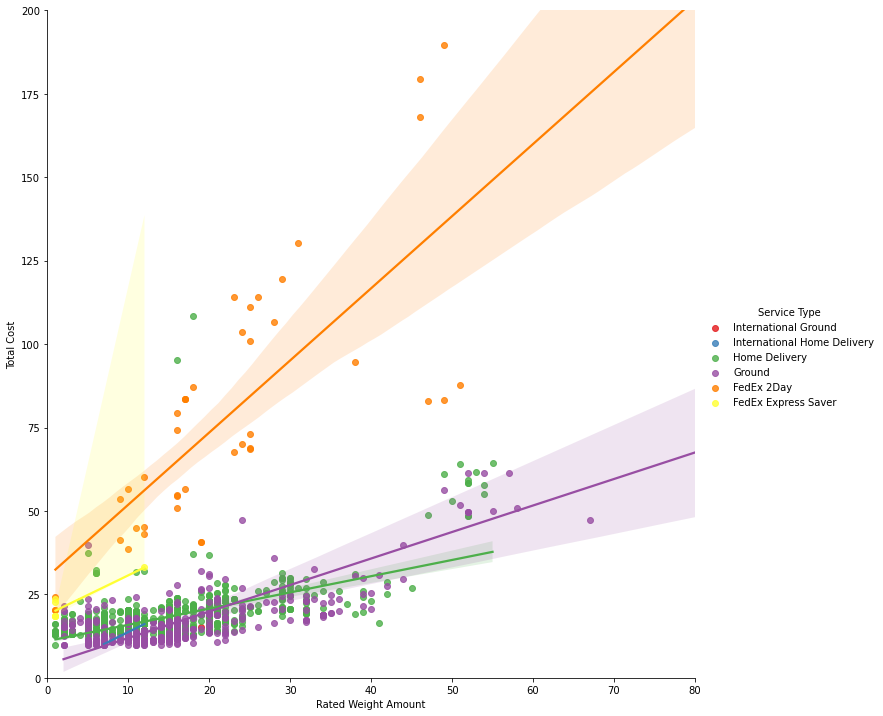

In [11]:
g = sns.lmplot(x="Rated Weight Amount", y="Total Cost", hue="Service Type", data=df,

               palette="Set1", height=10, legend='top right');

plt.xlim(0, 80);
plt.ylim(0, 200);

In [12]:
# Explore Data 

df_expore = df[df['Rated Weight Amount'] == 20]
df_expore['Total Cost'].describe()

count    104.000000
mean      19.386731
std        3.834655
min       13.470000
25%       16.200000
50%       19.100000
75%       21.630000
max       36.750000
Name: Total Cost, dtype: float64

In [13]:
# to csv
df.to_csv('expore.csv', header=True, index=False)